In [1]:
import numpy as np
from datetime import datetime as dt,timedelta
import xarray as xr
import netCDF4 as nc
import os
import copy
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cftime
# import xesmf as xe
import matplotlib.pyplot as plt
from lib import driver
# from lib import plot 
from lib.tools import get_categorical_obs, get_categorical_fcst, get_heidke, get_rpss
# from lib import verif
from lib.tools import *

ERROR 1: PROJ: proj_create_from_database: Open of /home/ycheng/.conda/envs/cpc/share/proj failed


In [2]:
def check_lat_order(dataset,verbose=False):
    """
    Check the order of latitude coordinates in the dataset.
    
    Parameters:
    - dataset: xarray.Dataset or xarray.DataArray
    
    Returns:
    - True if latitude is ordered from North to South (N to S).
    - False if latitude is ordered from South to North (S to N).
    - None if the order is ambiguous or the dataset is empty.
    """
    if 'latitude' in dataset.coords:
        dataset = dataset.rename_dims({'latitude': 'lat', 'longitude': 'lon'})

    lat_coords = dataset['lat']
    lat_diff = lat_coords.diff(dim='lat')
    if verbose:
        print(lat_diff)

    if (lat_diff < 0.).all():
        dataset= dataset.sel(lat=dataset.lat[::-1])
        print('change latitude from S to N')
        # print(dataset.lat)
    elif (lat_diff > 0.).all():
        dataset = dataset
        print('====latitude from S to N----')
        # print(dataset.lat)
    else:
        print('!!!!!! Latitude ambiguous or unordered !!!!!!')
    return(dataset)


In [3]:
from lib import getCPCobs
from lib.getCPCobs import *
import xskillscore as xs

In [4]:
varname = 'T2m'
VERIFDIR = f'/Projects/jalbers_process/CPC_LIM/yuan_ming/CPC/Images_v2p0_reforecast/'
anomvar = varname+'_anom'
spreadvar = varname+'_spread' 

start_date = "2019-01-01"
end_date   = "2019-12-31"
date_range = pd.date_range(start=start_date, end=end_date)
# files = [os.path.join(VERIFDIR,'T2m',f'{varname}.{date}.nc') for date in date_range.strftime('%Y%m%d')]
files = [os.path.join(VERIFDIR, date, varname,f'{varname}.{date}.nc') for date in date_range.strftime('%Y%m%d')]
ds = xr.open_mfdataset(files)
ds = check_lat_order(ds,verbose=False)

for label,lt in zip(['wk34'],[(21,28)]):
    # new dataset with current lead time. if more than one, concatenate lead times
    newds = xr.concat([ds.sel(lead_time=f'{i} days') for i in lt],dim='lead_time').mean('lead_time')
    anom   = newds[anomvar]
    spread = newds[spreadvar]

change latitude from S to N


In [5]:
# dsJ = xr.open_dataset('/home/ycheng/LIM/Scoring_John_code/2019.nc')
# dsJ = check_lat_order(dsJ,verbose=False)
# obs_J = dsJ['cpc_anom_week34'] 
# anom_J= dsJ['lim']



In [6]:
ds_obs = xr.open_dataset('/Projects/jalbers_process/CPC_LIM/t2m_data_for_scoring/final_v2_11.27.2023/T2m.cpc.grid2.ForecastLead_34.2019to2019.nc')
ds_obs = check_lat_order(ds_obs,verbose=False)
# obs = ds_obs['cpc_anom_week34_unmasked']
obs = ds_obs['cpc_anom_week34']
obs
# obs.isel(time=0).plot()

anom_J = ds_obs['lim_week34']


====latitude from S to N----


In [7]:
ds_jra = xr.open_dataset('/Projects/jalbers_process/CPC_LIM/t2m_data_for_scoring/final_v2_11.27.2023/T2m.jra55.grid2.ForecastLead_34.2019to2019.nc')

# Access the variable
obs_jra = ds_jra['cpc_anom_week34']
obs_jra = obs_jra.rename({'lons': 'lon'})
obs_jra = obs_jra.rename({'lats': 'lat'})
obs_jra = obs_jra.assign_coords(lon=ds_jra.lon.data)
obs_jra = obs_jra.assign_coords(lat=ds_jra.lat.data)
print(obs_jra)
# Print the updated variable

anom_J = ds_jra['lim_week34']
anom_J = anom_J.rename({'lons': 'lon'})
anom_J = anom_J.rename({'lats': 'lat'})
anom_J = anom_J.assign_coords(lon=ds_jra.lon.data)
anom_J = anom_J.assign_coords(lat=ds_jra.lat.data)
anom_J

<xarray.DataArray 'cpc_anom_week34' (time: 365, lat: 91, lon: 180)>
[5978700 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0
Dimensions without coordinates: time


<xarray.DataArray 'lim_week34' (time: 365, lat: 91, lon: 180)>
[5978700 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0
Dimensions without coordinates: time

In [8]:
# anom_J.isel(time=50,lats=slice(45,86),lons=slice(85,150)).plot()

In [9]:
# anom.isel(time=50,lat=slice(45,86),lon=slice(85,150)).plot()
# import warnings
# warnings.filterwarnings("ignore")

In [ ]:
vCPC = xr.concat([obs_jra.isel(time=i)],dim='time').mean(dim='time')
ANOM = anom_J.isel(time=i)
SPREAD = spread.isel(time=i)
mask   = xr.where(ANOM.isnull() | vCPC.isnull() | SPREAD.isnull() ,np.nan  ,1.)
print(vCPC.lat)
# print(ANOM)
print(SPREAD.lat)
# print(mask)

In [72]:
# skill_HSS = []
# probability = []
# observation = []

# import warnings
# warnings.filterwarnings("ignore")
# import time

# # mask    = xr.where(obs_jra.isnull() | anom_J.isnull() | spread.isnull() ,np.nan  ,1.)
# # obs_jra = obs_jra.where(~mask.isnull(), drop=True)
# # anom_J  = anom_J.where(~mask.isnull(), drop=True)
# # spread  = spread.where(~mask.isnull(), drop=True)
# for i, date in enumerate(date_range):
# # for i in np.array([0,1,2,3,4]):
#     print(date)
#     vCPC = obs_jra.isel(time=i)
#     ANOM = anom_J.isel(time=i)
#     SPREAD = spread.isel(time=i)
#     mask   = xr.where(ANOM.isnull() | vCPC.isnull() | SPREAD.isnull() ,np.nan  ,1.)


#     # Apply the mask to the datasets
#     vCPC = vCPC.where(~mask.isnull(), drop=True)
#     ANOM = ANOM.where(~mask.isnull(), drop=True)
#     SPREAD = SPREAD.where(~mask.isnull(), drop=True)
   
#     vCPC   = np.array(vCPC)[vCPC.notnull()]
#     ANOM   = np.array(ANOM)[ANOM.notnull()]
#     SPREAD = np.array(SPREAD)[SPREAD.notnull()]

#     bounds = [-np.inf*np.ones(len(vCPC)),np.zeros(len(vCPC)),np.inf*np.ones(len(vCPC))]
#     OBS = get_categorical_obs((vCPC,),bounds)[0]

#     bounds = [-np.inf*np.ones(len(ANOM)),np.zeros(len(ANOM)),np.inf*np.ones(len(ANOM))]
#     PROB = get_categorical_fcst((ANOM,),(SPREAD,),bounds)[0]

#     HSS = get_heidke(PROB.T,OBS.T,categorical=True)

#     skill_HSS.append(HSS)
#     probability.append(PROB)
#     observation.append(OBS)


In [73]:
skill_HSS = skill_JRA

In [68]:
ds = xr.Dataset(
    {
        'observation':(['time','event','point'],np.array(observation)),
        'probability':(['time','event','point'],np.array(probability)),
        'HSS':(['time'],np.array(skill_HSS)),
    },
    coords={
        'time': date_range,
        'event': ('event',np.array([0,1]),{'long_name': 'cold and warm event probability'}),
        'point': np.arange(np.array(probability).shape[2]),
    }
)
ds

<xarray.Dataset>
Dimensions:      (time: 365, event: 2, point: 282)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
  * event        (event) int64 0 1
  * point        (point) int64 0 1 2 3 4 5 6 7 ... 275 276 277 278 279 280 281
Data variables:
    observation  (time, event, point) bool True False False ... True True True
    probability  (time, event, point) float64 0.5543 0.5323 ... 0.5197 0.5217
    HSS          (time) float64 0.4823 0.7376 0.766 ... 0.02128 0.1986 0.1844

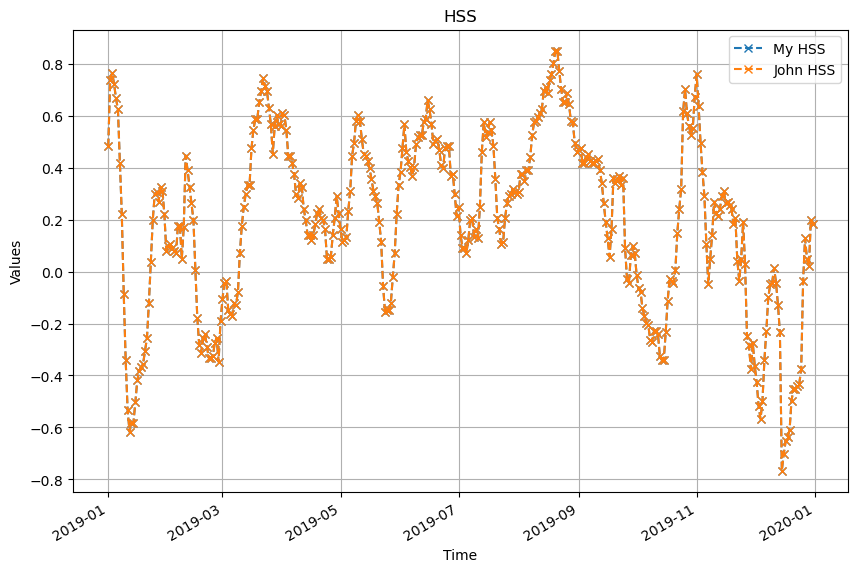

In [34]:
dsHSS= xr.Dataset({"HSS":(['time'],skill_JRA)}, coords={'time':date_range})
dsHSSJ = xr.Dataset({"HSS":(['time'],mat_data['HSS_LIM'][0])},coords={'time':date_range})

# Plotting
plt.figure(figsize=(10, 6))

# Plot HSS
# hss_data.plot(label='Reproduced HSS', marker='o', linestyle='-')

# Plot HSS_J
# hss_j_data.plot(label='John HSS', marker='x', linestyle='--')

dsHSS['HSS'].plot(label='My HSS', marker='x', linestyle='--')
dsHSSJ['HSS'].plot(label='John HSS', marker='x', linestyle='--')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('HSS')
plt.legend()
plt.grid(True)

In [55]:
ds['HSS'].mean()

<xarray.DataArray 'HSS' ()>
array(0.19931993)

In [56]:
import scipy.io

# Load .mat file
mat_data = scipy.io.loadmat('/Projects/jalbers_process/CPC_LIM/t2m_data_for_scoring/scoring_data/final_v2_11.27.2023/jra55/scoring_data_2019.mat')
mat_data['HSS_LIM'].mean()
# Access variables in the loaded data
# variable_name = 'your_variable_name'
# your_variable = mat_data[variable_name]

0.199319926163412

In [69]:
year_all = date_range.year
year = year_all.unique()[0]
print(year)


2019


In [71]:
SCORDIR = f'{VERIFDIR}/verification'
fout = f'{SCORDIR}/{year}.nc'
os.system(f'mkdir -p {SCORDIR}')
os.system(f'rm -f {fout}')
ds.to_netcdf(fout)